# Guardians of the Memory - Modeling - Felix

**Contents**:
1. Preprocessing and feature engineering
2. Modeling
    * 2.1. Defining functions
    * 2.2. XGBoost Classifier
    * 2.3. GaussianNB
    * 2.4. Isolation Forest
    * 2.5. Artificial Neural Network
    * 2.6. Stacking
3. Model export
4. Error analysis

### Import Libraries

In [55]:
import warnings # Turn off warnings
warnings.filterwarnings('ignore')

import os # Import own functions
import sys
sys.path.append("..") # Fix folder structure
from src.data.hdd_preprocessing import load_preprocess_data, train_test_splitter, calculate_target
from src.features.feature_engineering import log_transformer, hdd_preprocessor

import pandas as pd # Pandas and Numpy
import numpy as np

import mlflow # MLFlow for experiment tracking
EXPERIMENT_NAME = "guardians_of_the_memory_felix"
TRACKING_URI = open("../.mlflow_uri").read().strip()

import seaborn as sns # Plotting libraries
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Sklearn for preprocessing and modeling
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest, StackingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# Sklearn metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, fbeta_score
from sklearn.metrics import make_scorer, precision_recall_curve, mean_squared_error

# Tensorflow and Keras
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.metrics import Recall, Precision
from keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from mlflow.sklearn import save_model

RSEED = 42 # Random seed for repeatability

# 1. Preprocessing and feature engineering


* We load the file containing the history 2019-2021 of the picked model.
* The target is calculated, then the data is preprocessed (dropping columns, dropping NaN rows and duplicate rows)
* We train-test split the data to prevent leakage during feature engineering. The data is split according to serial numbers (so all history of one drives ends up in either the train or the test set)
* The preprocessor generates the features. Although the first call uses `fit`, nothing is fitted here.
* Next we define a pipeline for scaling. We use our custom log_transformer and scale the data using MinMaxScaling.

In [16]:
repo_path = os.getcwd()+"/../" # Path to the parent directory
# Loading and preprocessing of the data
X, y = load_preprocess_data(days=30, filename="ST4000DM000_history_total", path=repo_path)
df_backup = X.copy() # Backup the original data
# Train-test split according to serial numbers
X_train, X_test, y_train, y_test = train_test_splitter(
        X, y, test_size=0.30, random_state=RSEED
        )
# Feature engineering
feat_eng = hdd_preprocessor(days=30, trigger=0.05)
X_train = feat_eng.fit_transform(X_train)
X_test = feat_eng.transform(X_test)
# Defing scaling pipeline
scaling_pipe = Pipeline([
                ('scaler_log', log_transformer(offset=1)),
                ('scaler_minmax ', MinMaxScaler()),
                ])

In [17]:
X_train_normal = X_train[y_train == 0]
y_train_normal = y_train[y_train == 0]
X_train_anomalous = X_train[y_train == 1]
y_train_anomalous = y_train[y_train == 1]

In [63]:
from src.data.preprocessing import countdown, load_drive_stats

df_c = load_drive_stats(filename="ST4000DM000_history_total", path=repo_path)
days = countdown(df_c).countdown

X_train["serial_number"] = df_c.serial_number[X_train.index]
X_train["countdown"] = days[X_train.index]
X_test["serial_number"] = df_c.serial_number[X_test.index]
X_test["countdown"] = days[X_test.index]


In [64]:
X_train_adj = X_train.pivot("serial_number", "countdown", "smart_999")
X_test_adj = X_test.pivot("serial_number", "countdown", "smart_999")

In [65]:
X_train_normal = X_train_adj.iloc[:,30:]
X_test_normal = X_test_adj.iloc[:,30:]
y_train_normal = np.zeros((1,len(X_train_normal)))
X_train_anomalous = X_train_adj.iloc[:,:30]
#y_train_anomalous = y_train[y_train == 1]

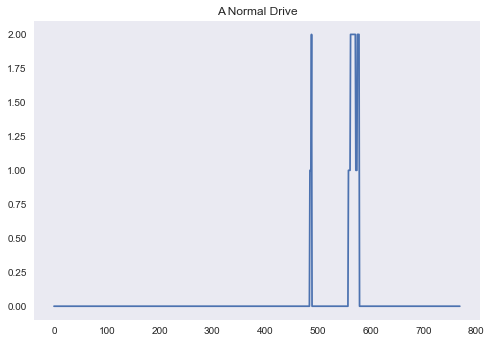

In [40]:
plt.grid()
plt.plot(np.arange(770), X_train_normal.iloc[0,:])
plt.title("A Normal Drive")
plt.show()

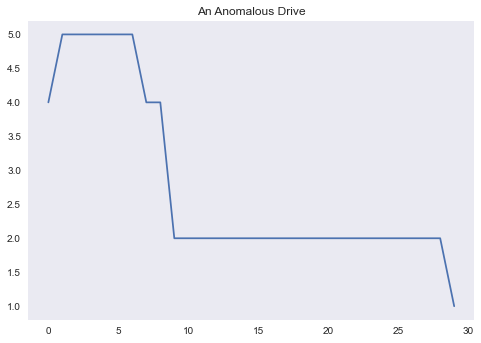

In [53]:
plt.grid()
plt.plot(np.arange(30), X_train_anomalous.iloc[29,:])
plt.title("An Anomalous Drive")
plt.show()

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


In [75]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(770, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.build(input_shape=(1,770))
autoencoder.summary()

Model: "anomaly_detector_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (1, 8)                    25336     
                                                                 
 sequential_13 (Sequential)  (1, 770)                  26098     
                                                                 
Total params: 51,434
Trainable params: 51,434
Non-trainable params: 0
_________________________________________________________________


In [67]:
X_train_normal.shape, X_test_normal.shape

((424, 770), (181, 770))

In [76]:
history = autoencoder.fit(X_train_normal, X_train_normal, 
          epochs=20, 
          batch_size=40,
          validation_data=(X_test_normal, X_test_normal),
          shuffle=True)

Epoch 1/20
 8/11 [====================>.........] - ETA: 0s - loss: nan  

2022-03-28 12:09:34.207212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 7s 32ms/step - loss: nan - val_loss: nan
Epoch 2/20
11/11 [==============================] - 0s 10ms/step - loss: nan - val_loss: nan
Epoch 3/20
 1/11 [=>............................] - ETA: 0s - loss: nan

2022-03-28 12:09:34.579872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 12ms/step - loss: nan - val_loss: nan
Epoch 4/20
11/11 [==============================] - 0s 11ms/step - loss: nan - val_loss: nan
Epoch 5/20
11/11 [==============================] - 0s 10ms/step - loss: nan - val_loss: nan
Epoch 6/20
11/11 [==============================] - 0s 10ms/step - loss: nan - val_loss: nan
Epoch 7/20
11/11 [==============================] - 0s 10ms/step - loss: nan - val_loss: nan
Epoch 8/20
11/11 [==============================] - 0s 8ms/step - loss: nan - val_loss: nan
Epoch 9/20
11/11 [==============================] - 0s 10ms/step - loss: nan - val_loss: nan
Epoch 10/20
11/11 [==============================] - 0s 11ms/step - loss: nan - val_loss: nan
Epoch 11/20
11/11 [==============================] - 0s 9ms/step - loss: nan - val_loss: nan
Epoch 12/20
11/11 [==============================] - 0s 10ms/step - loss: nan - val_loss: nan
Epoch 13/20
11/11 [==============================] - 0s 10ms/step - loss: nan - 